In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
import tqdm as notebook_tqdm

In [2]:
MNIST_train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

MNIST_test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("MNIST_train_dataset size:", len(MNIST_train_dataset),"\nMNIST_test_dataset size:", len(MNIST_test_dataset))

MNIST_train_dataset size: 60000 
MNIST_test_dataset size: 10000


In [3]:
def MNIST_train_loader(batch_size):
    MNIST_train_loader = torch.utils.data.DataLoader(dataset=MNIST_train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return MNIST_train_loader


def MNIST_test_loader(batch_size):
    MNIST_test_loader = torch.utils.data.DataLoader(dataset=MNIST_test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return MNIST_test_loader

In [4]:
class M1(nn.Module):
  def __init__(self,):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)
        
  def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [5]:
len(MNIST_train_loader(6000))

10

In [6]:
def trainFunction(model,num_epochs,train_batch_size,status):
    model.train()
    print('Started')
    train_load = MNIST_train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged =True
    epoch = 0
    trainAvgLossArr = []
    trainAvgAccArr = []

    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc =0

        for i, (images, labels) in enumerate(train_load):  
            
            images, labels = Variable(images),Variable(labels)

            optimizer.zero_grad()

            prediction = model(images)
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            loss.backward()
            
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            if (i+1) % status == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
   
                if epoch == num_epochs:
                        print("Max Epoch Reached")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False

       
        epochAcc = totalacc/(i+1)
        trainAvgLossArr.append(lossSum/n_total_steps)    
        trainAvgAccArr.append(epochAcc)

    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr

In [7]:
torch.manual_seed(1)

learning_rate = 0.0015
mBatch1 = M1()
loss_func = nn.CrossEntropyLoss()
weight_decay_val = 1e-4

optimizer = torch.optim.Adam(mBatch1.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]
for i in mBatch1.parameters():
    a.append(torch.numel(i))
print(f'Total no. of parameters in Model with batch_size={64} is:{np.sum(a)}')

Total no. of parameters in Model with batch_size=64 is:397510


In [8]:
max_epochs = 5
train_batch_size = 64
status = 500
B1_train_epoch,B1_train_losses,B1_train_acc,B1trainAvgLossArr,B1trainAvgAccArr  = trainFunction(mBatch1,max_epochs,train_batch_size,status)

Started
Max Epoch Reached[5/5], Step [500/938], Loss: 0.0577


In [9]:
torch.manual_seed(1)

learning_rate = 0.0001
mBatch2 = M1()
loss_func = nn.CrossEntropyLoss()
weight_decay_val = 1e-4
optimizer = torch.optim.Adam(mBatch2.parameters(), lr=learning_rate, weight_decay=weight_decay_val) 
#optimizer = torch.optim.SGD(mBatch2.parameters(), lr=learning_rate)

a=[]
for i in mBatch2.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters in Model with batch_size={1000} is:{np.sum(a)}')

Total no of parameters in Model with batch_size=1000 is:397510


In [10]:
max_epochs = 5
train_batch_size = 1000
status = 10
B2_train_epoch,B2_train_losses,B2_train_acc,B2trainAvgLossArr,B2trainAvgAccArr = trainFunction(mBatch2,max_epochs,train_batch_size,status)

Started
Max Epoch Reached[5/5], Step [10/60], Loss: 0.5009
Max Epoch Reached[5/5], Step [20/60], Loss: 0.4638
Max Epoch Reached[5/5], Step [30/60], Loss: 0.4239
Max Epoch Reached[5/5], Step [40/60], Loss: 0.4387
Max Epoch Reached[5/5], Step [50/60], Loss: 0.4361
Max Epoch Reached[5/5], Step [60/60], Loss: 0.4106


In [11]:
epochArr = np.array(np.linspace(1,max_epochs,max_epochs))

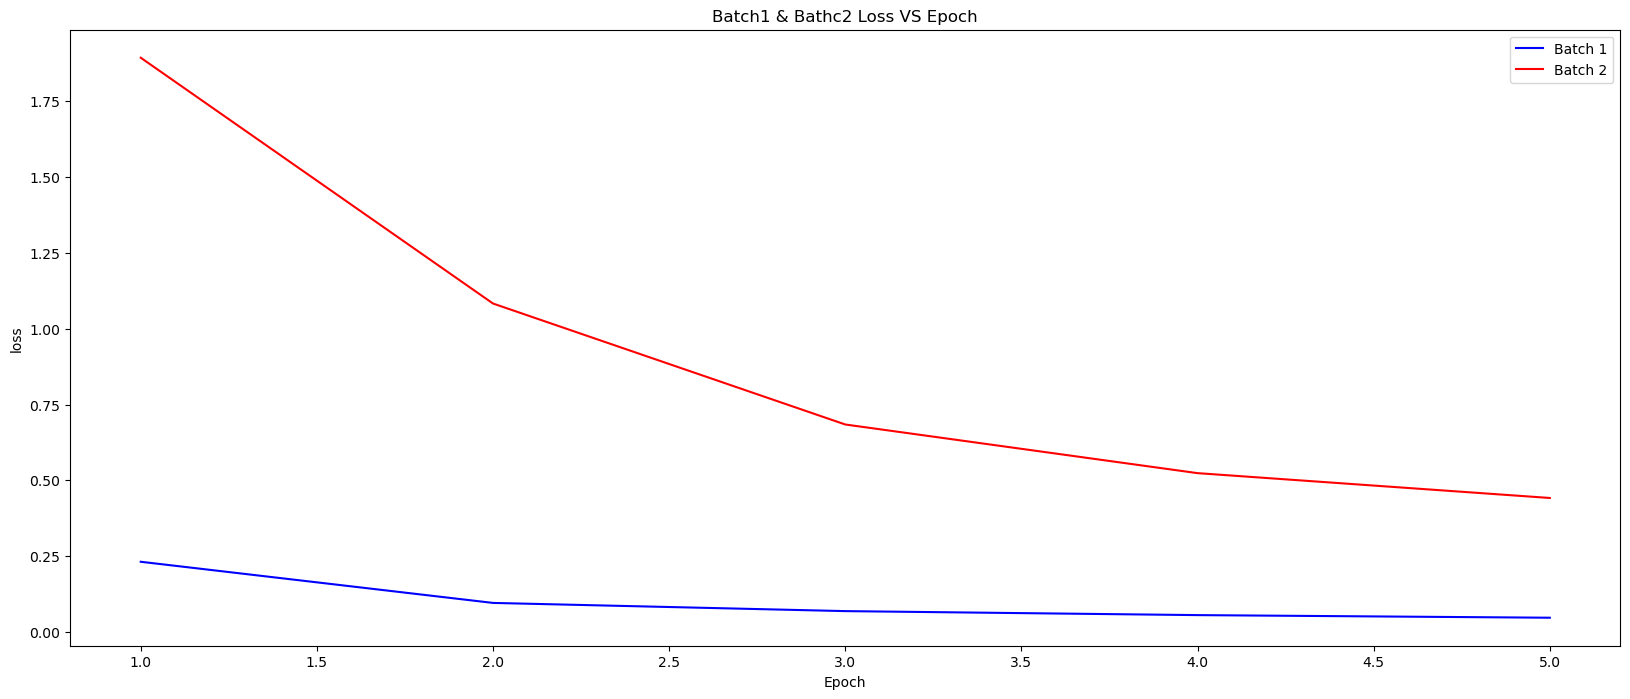

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(epochArr,B1trainAvgLossArr,color="blue")
plt.plot(epochArr,B2trainAvgLossArr,color="red")
plt.title('Batch1 & Bathc2 Loss VS Epoch')
plt.legend(['Batch 1','Batch 2'])
plt.xlabel ('Epoch')
plt.ylabel ('loss')
plt.show()

In [13]:
batch1_param = torch.nn.utils.parameters_to_vector(mBatch1.parameters())
print(batch1_param,'\nlen:',len(batch1_param))

tensor([-1.8829e-38, -3.4748e-39,  1.8334e-37,  ..., -5.1062e-02,
         1.1912e-01, -6.0722e-03], grad_fn=<CatBackward0>) 
len: 397510


In [14]:
batch2_param = torch.nn.utils.parameters_to_vector(mBatch2.parameters())
print(batch2_param,'\nlen:',len(batch2_param))

tensor([ 1.2313e-03, -5.0379e-04, -8.0190e-09,  ...,  5.2469e-02,
        -6.5171e-02, -2.0972e-02], grad_fn=<CatBackward0>) 
len: 397510


In [15]:
alpha = np.linspace(-2.0, 2.0, num=31)
print(alpha)

[-2.         -1.86666667 -1.73333333 -1.6        -1.46666667 -1.33333333
 -1.2        -1.06666667 -0.93333333 -0.8        -0.66666667 -0.53333333
 -0.4        -0.26666667 -0.13333333  0.          0.13333333  0.26666667
  0.4         0.53333333  0.66666667  0.8         0.93333333  1.06666667
  1.2         1.33333333  1.46666667  1.6         1.73333333  1.86666667
  2.        ]


In [16]:
thetaArr =[]
for i in range (len(alpha)):
    theta = (1-alpha[i])*batch1_param + alpha[i]*batch2_param
    thetaArr.append(theta)

In [17]:
def testFunction(model,loss_func,testLoader,test_batch_size): 
    MNIST_test_loader = testLoader
    test_load = MNIST_test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count =0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count +=1

    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1} & Test Loss: {netTest_loss} %', end="\r", flush= True)
    return netTest_acc1, netTest_loss

In [18]:
import copy

In [ ]:
modelsTrainEpochArr = []
modelsTrainLossArr = []
modelsTrainAccArr = []
modelsTestLossArr = []
modelsTestAccArr = []

for i in range (len(thetaArr)):
    #torch.manual_seed(1)
    
    j=copy.deepcopy(i) 
    theta = (1-alpha[i])*batch1_param + alpha[i]*batch2_param
    j = M1()
    torch.nn.utils.vector_to_parameters(theta,j.parameters())
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(j.parameters(), lr=0.0004, weight_decay = 1e-4)
    

    a=[]
    for k in j.parameters():
        a.append(torch.numel(k))
    print(f'Total no of parameters in Model Theta {i} is:{np.sum(a)}')

    print(j.parameters)

    max_epochs = 1
    train_batch_size = 500
    status = 100
    T_train_epoch,T_train_losses,T_train_acc,T_trainAvgLossArr,T_trainAvgAccArr = trainFunction(j,max_epochs,train_batch_size,status)
    
    
    
    modelsTrainLossArr.append(T_trainAvgLossArr)
    modelsTrainAccArr.append(T_trainAvgAccArr)
    
    test_batch_size=500
    T_acc, T_testLoss = testFunction(j,loss_func,MNIST_test_loader,test_batch_size)
    modelsTestAccArr.append(T_acc)
    modelsTestLossArr.append(T_testLoss)

Total no of parameters in Model Theta 0 is:397510
<bound method Module.parameters of M1(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)>
Started
Max Epoch Reached[1/1], Step [100/120], Loss: 0.0354
Total no of parameters in Model Theta 1 is:397510 & Test Loss: 0.20809566435382293 %
<bound method Module.parameters of M1(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)>
Started
Max Epoch Reached[1/1], Step [100/120], Loss: 0.0668
Total no of parameters in Model Theta 2 is:397510 & Test Loss: 0.1932235491271058 %
<bound method Module.parameters of M1(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)>
Started
Max Epoch Reached[1/1], Step [100/120], Loss: 0.1015
Total no of parameters in Model Theta 3 is:397510 & Test Loss: 0.17515208631048154 %
<bound method Modu

In [ ]:
fig,ax=plt.subplots()
ax.plot(alpha,(modelsTrainLossArr),color="Blue",linestyle='dashed', marker="o")
ax.plot(alpha,modelsTestLossArr,color="Blue", marker="v")
ax.legend(['Train Loss','Test Loss'],loc="center left")
ax.set_xlabel("Alpha",color="Green")
ax.set_ylabel("CrossEntropy Loss",color = "blue")


ax2=ax.twinx()
ax2.plot(alpha,(modelsTrainAccArr),color="red",linestyle='dashed', marker="o")
ax2.plot(alpha,modelsTestAccArr,color="red", marker="v")
ax2.set_xlabel("Alpha",color="Green")
ax2.set_ylabel("Accuracy",color = "red")
ax2.legend(['Train Acc','Test Acc'],loc="upper right")

plt.show()

In [ ]:
torch.manual_seed(1)

learning_rate = 1e-3
mLr1 = M1()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mLr1.parameters(), lr=learning_rate) 

a=[]
for i in mLr1.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters in Model with Lr={learning_rate} is:{np.sum(a)}')

In [ ]:
max_epochs = 5
train_batch_size = 64
status = 10
L1_train_epoch,L1_train_losses,L1_train_acc,L1_trainAvgLossArr,L1_trainAvgAccArr  = trainFunction(mLr1,max_epochs,train_batch_size,status)

In [ ]:
Lr1_param = torch.nn.utils.parameters_to_vector(mLr1.parameters())
print(Lr1_param,'\nlen:',len(Lr1_param))

In [ ]:
torch.manual_seed(1)
learning_rate = 1e-2
mLr2 = M1()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mLr2.parameters(), lr=learning_rate) 

a=[]
for i in mLr2.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters in Model with Lr={learning_rate} is:{np.sum(a)}')

In [ ]:
max_epochs = 5
train_batch_size = 64
status = 10
L2_train_epoch,L2_train_losses,L2_train_acc,L2_trainAvgLossArr,L2_trainAvgAccArr  = trainFunction(mLr2,max_epochs,train_batch_size,status)

In [ ]:
epochArr = np.array(np.linspace(1,max_epochs,max_epochs))

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(epochArr,L1_trainAvgLossArr,color="blue")
plt.plot(epochArr,L2_trainAvgLossArr,color="orange")
plt.title('Lr1 & Lr2 Loss VS Epoch',color="green")
plt.legend(['LR1:1e-3 1','LR2:1e-2'])
plt.xlabel ('Epoch')
plt.ylabel ('loss')
plt.show()

In [ ]:
Lr2_param = torch.nn.utils.parameters_to_vector(mLr2.parameters())
print(Lr2_param,'\nlen:',len(Lr2_param))

In [ ]:
modelsTrainEpochArr2 = []
modelsTrainLossArr2 = []
modelsTrainAccArr2 = []
modelsTestLossArr2 = []
modelsTestAccArr2 = []

for i in range (len(thetaArr)):
    torch.manual_seed(1)
    j=copy.deepcopy(i) 
    theta = (1-alpha[i])*Lr1_param + alpha[i]*Lr2_param
    j = M1()
    torch.nn.utils.vector_to_parameters(theta,j.parameters())
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(j.parameters(), lr=1e-3) #,weight_decay = 0.025)

    a=[]
    for k in j.parameters():
        a.append(torch.numel(k))
    print(f'Total no of parameters in Model Theta {i} is:{np.sum(a)}')

    print(j.parameters)

    max_epochs = 1
    train_batch_size = 1000
    status = 60
    T2_train_epoch,T2_train_losses,T2_train_acc,T2_trainAvgLossArr,T2_trainAvgAccArr = trainFunction(j,max_epochs,train_batch_size,status) #trainFunction(mBatch1,max_epochs,train_batch_size)
    
    
    #modelsTrainEpochArr2.append(T2_trainAvgLossArr)
    modelsTrainLossArr2.append(T2_trainAvgLossArr)
    modelsTrainAccArr2.append(T2_trainAvgAccArr)
    
    test_batch_size=1000
    T2_acc,T2_testLoss = testFunction(j,loss_func,MNIST_test_loader,test_batch_size)
    modelsTestAccArr2.append(T2_acc)
    modelsTestLossArr2.append(T2_testLoss)

In [ ]:
fig,ax=plt.subplots()
ax.plot(alpha,(modelsTrainLossArr2),color="Blue",linestyle='dashed', marker="o")
ax.plot(alpha,modelsTestLossArr2,color="Blue", marker="v")
ax.legend(['Train Loss','Test Loss'],loc="center left")
ax.set_xlabel("Alpha",color="Green")
ax.set_ylabel("CrossEntropy Loss",color = "blue")
ax.set_title("learning rate 1e-3 vs. 1e-2",color = "green")


ax2=ax.twinx()
ax2.plot(alpha,(modelsTrainAccArr2),color="red",linestyle='dashed', marker="o")
ax2.plot(alpha,modelsTestAccArr2,color="red", marker="v")
ax2.set_xlabel("Alpha",color="Green")
ax2.set_ylabel("Accuracy",color = "red")
ax2.legend(['Train Acc','Test Acc'],loc="upper right")

plt.show()
